# IMPORTS

In [1]:
import re, math, os, cv2, random, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

2024-04-28 15:31:40.120541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 15:31:40.120676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 15:31:40.244186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Helper Functions

In [2]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
                      
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'target': tf.io.FixedLenFeature([], tf.int64), 
        'image_name': tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    target = example['target']
    name = example['image_name']
    return image, target, name

def load_dataset(filenames, HEIGHT, WIDTH, CHANNELS=3):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        image, label, name = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(image[0])
        plt.title(f"{label[0]}: {name[0].numpy().decode('utf-8')}", fontsize=12)
    plt.show()

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Create TF Records
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, target, image_name):
  feature = {
      'image': _bytes_feature(image),
      'target': _int64_feature(target),
      'image_name': _bytes_feature(image_name),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

# PARAMETER DECLARATION

You can modify the Height and Width of the Image based on your model. Also you can modify the number of File Splits you require as well.

In [3]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
PATH = f'{database_base_path}train_images/'
IMGS = os.listdir(PATH)
N_FILES = 5 # split images into 10 files
HEIGHT, WIDTH = (512, 512)
IMG_QUALITY = 100

print(f'Image samples: {len(IMGS)}')

Image samples: 21397


# Load Data

In [4]:
train = pd.read_csv(database_base_path + 'train.csv')
print('Train samples: %d' % len(train))
display(train.head())

Train samples: 21397


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
# Check for NaN values in the DataFrame
nan_counts = train.isna().sum()

# Print the count of NaN values in each column
print("Count of NaN values per column:")
print(nan_counts)

Count of NaN values per column:
image_id    0
label       0
dtype: int64


# Generate Files

In [6]:
folds = StratifiedKFold(n_splits=N_FILES, shuffle=True, random_state=seed)
train['file'] = -1

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train, train['label'])):
    print('File: %s has %s samples' % (fold_n+1, len(val_idx)))
    train['file'].loc[val_idx] = fold_n
    
display(train.head())
display(train.describe())
train.to_csv('train.csv', index=False)

File: 1 has 4280 samples
File: 2 has 4280 samples
File: 3 has 4279 samples
File: 4 has 4279 samples
File: 5 has 4279 samples


,image_id,label,file
0,1000015157.jpg,0,3
1,1000201771.jpg,3,0
2,100042118.jpg,1,1
3,1000723321.jpg,1,1
4,1000812911.jpg,3,4


,label,file
count,21397.000000,21397.000000
mean,2.651914,1.999860
std,0.988565,1.414263
min,0.000000,0.000000
25%,2.000000,1.000000
50%,3.000000,2.000000
75%,3.000000,3.000000
max,4.000000,4.000000


# Generate TF Records

In [7]:
for tfrec_num in range(N_FILES):
    print('\nWriting TFRecord %i of %i...'%(tfrec_num, N_FILES))
    samples = train[train['file'] == tfrec_num]
    n_samples = len(samples)
    print(f'{n_samples} samples')
    with tf.io.TFRecordWriter('Id_train%.2i-%i.tfrec'%(tfrec_num, n_samples)) as writer:
        for row in samples.itertuples():
            label = row.label
            image_name = row.image_id
            img_path = f'{PATH}{image_name}'
            
            img = cv2.imread(img_path)
            img = cv2.resize(img, (HEIGHT, WIDTH))
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tostring()
            
            example = serialize_example(img, label, str.encode(image_name))
            writer.write(example)


Writing TFRecord 0 of 5...
4280 samples

Writing TFRecord 1 of 5...
4280 samples

Writing TFRecord 2 of 5...
4279 samples

Writing TFRecord 3 of 5...
4279 samples

Writing TFRecord 4 of 5...
4279 samples


# Visualization

TFRecords files: ['./Id_train00-4280.tfrec', './Id_train02-4279.tfrec', './Id_train01-4280.tfrec', './Id_train04-4279.tfrec', './Id_train03-4279.tfrec']
Created image samples: 21397


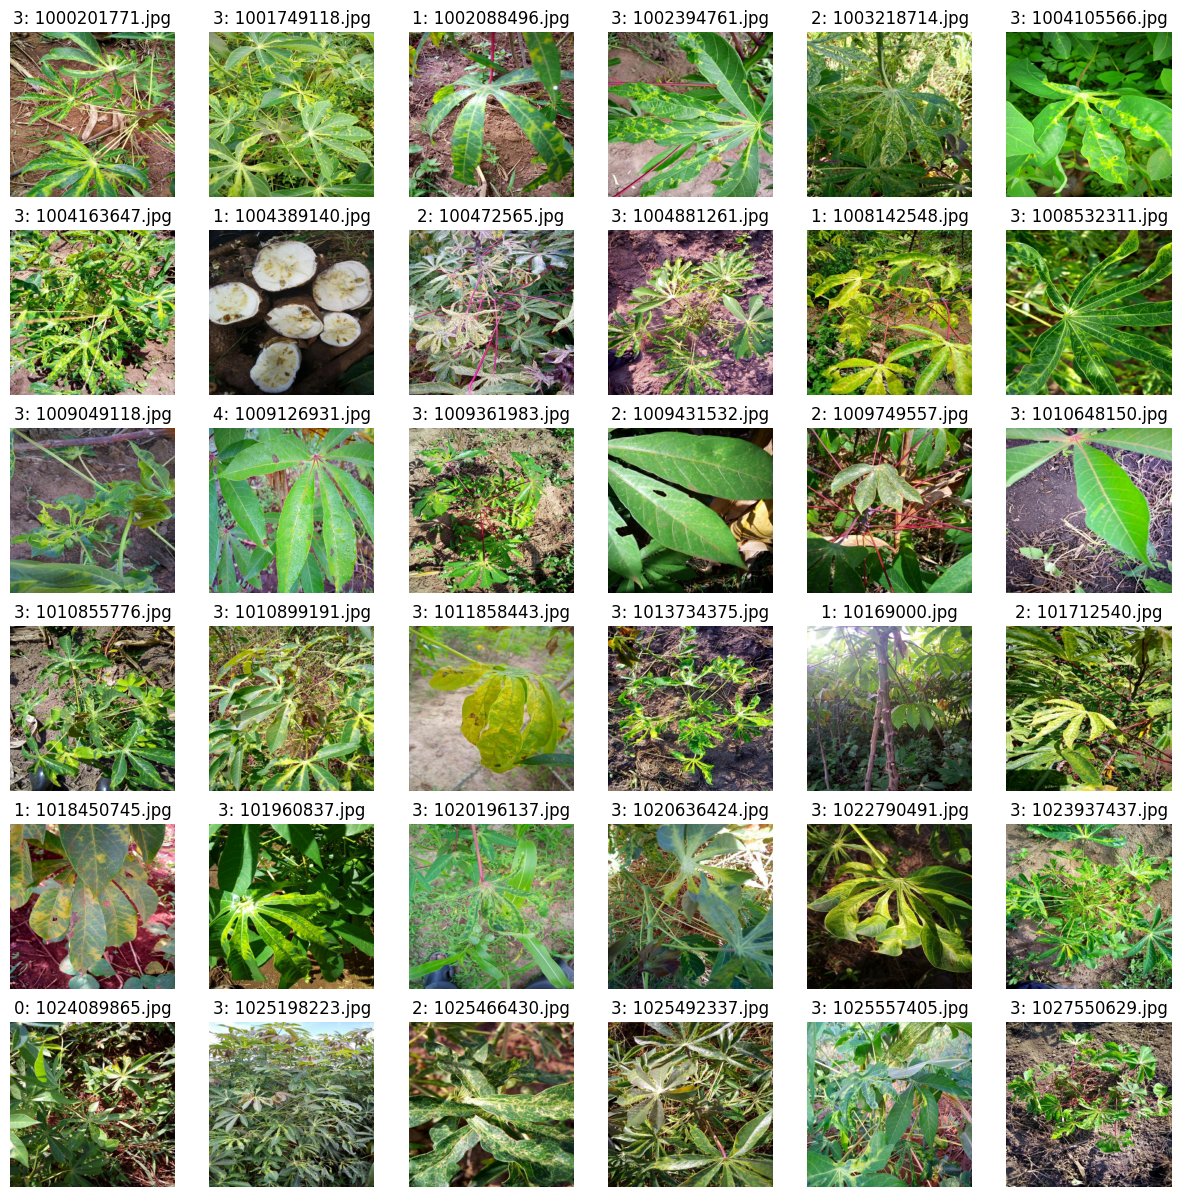

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('Id_train*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)

# Complete Set Label Distribution


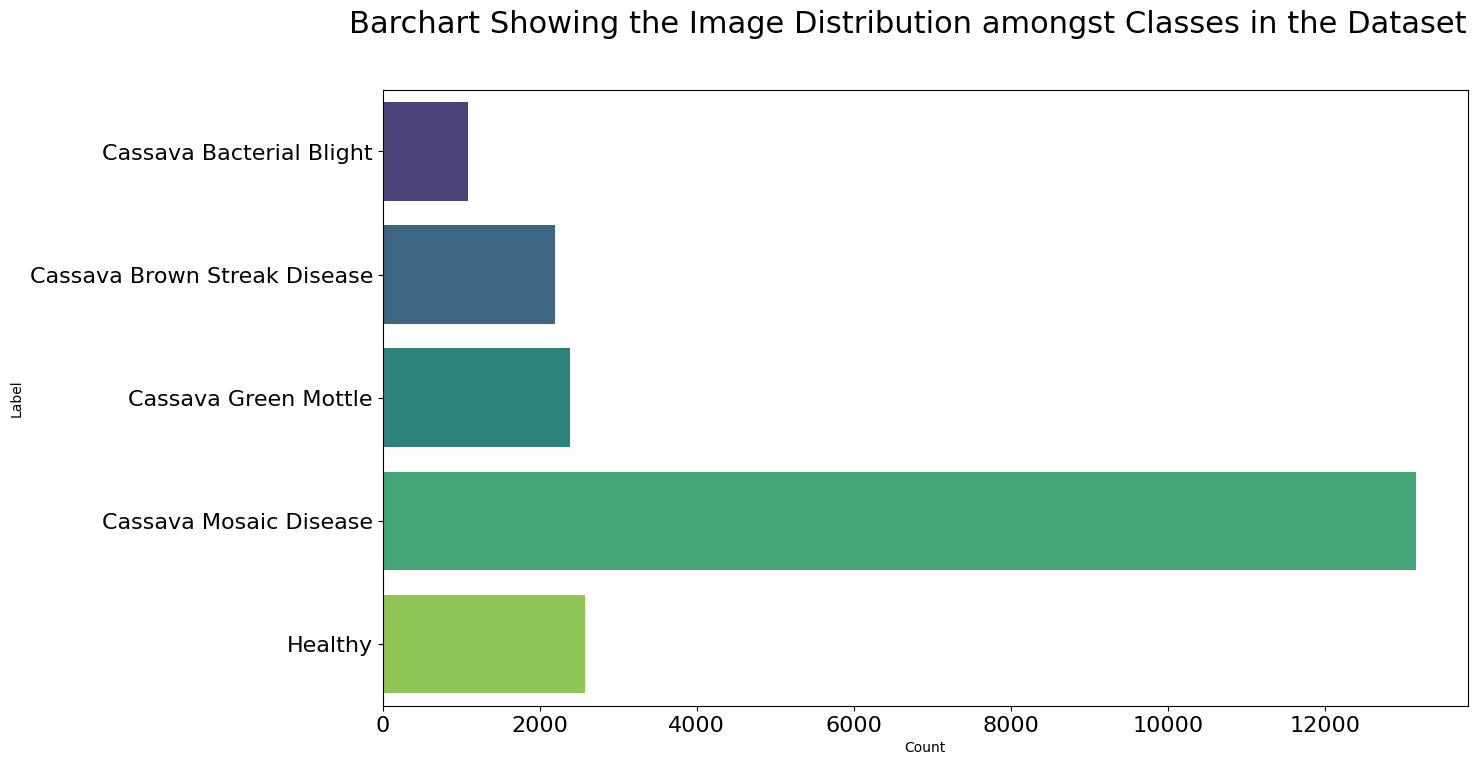

In [9]:
CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

label_count = train.groupby('label', as_index=False).count()
label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
fig.suptitle(f'Barchart Showing the Image Distribution amongst Classes in the Dataset', fontsize=22)
ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

# Label Distribution for each File

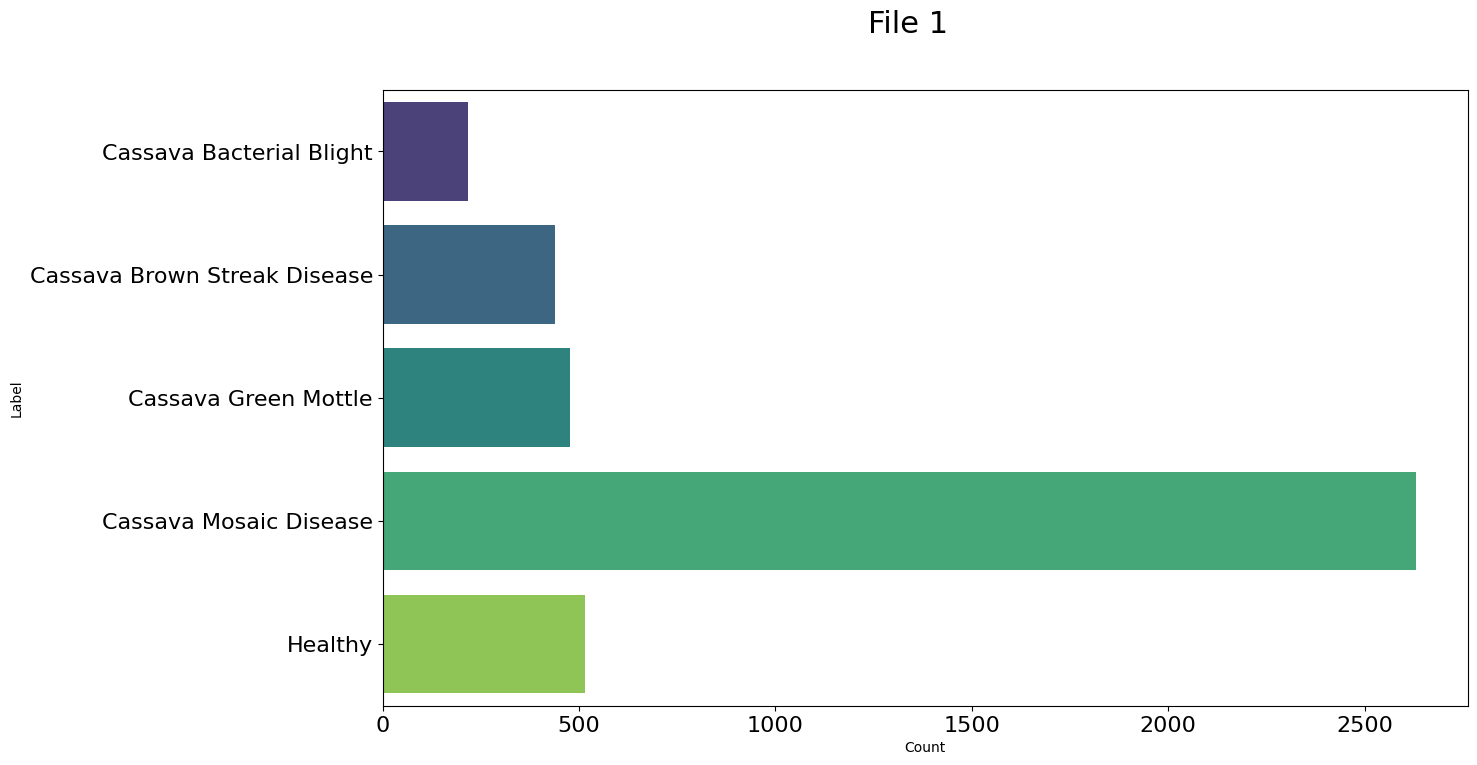

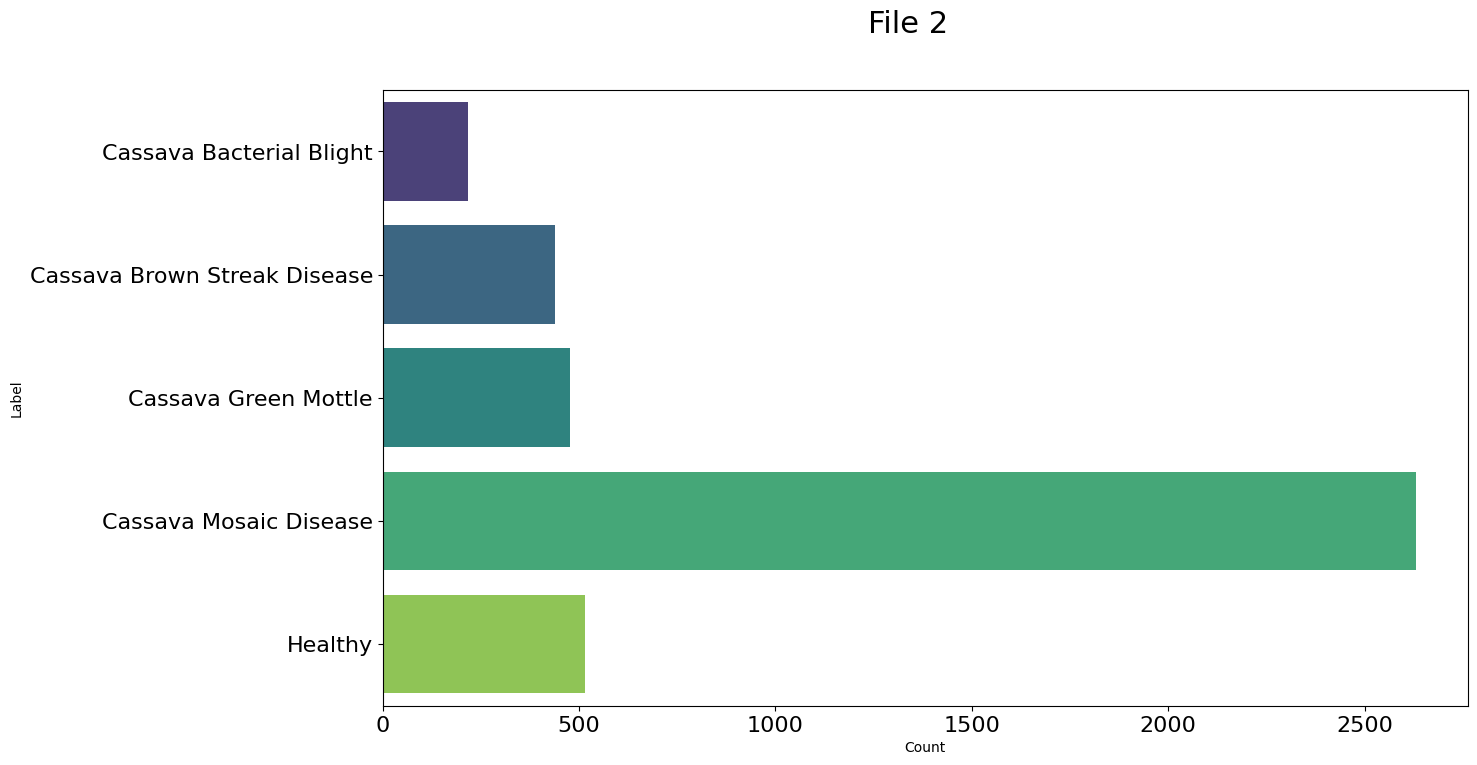

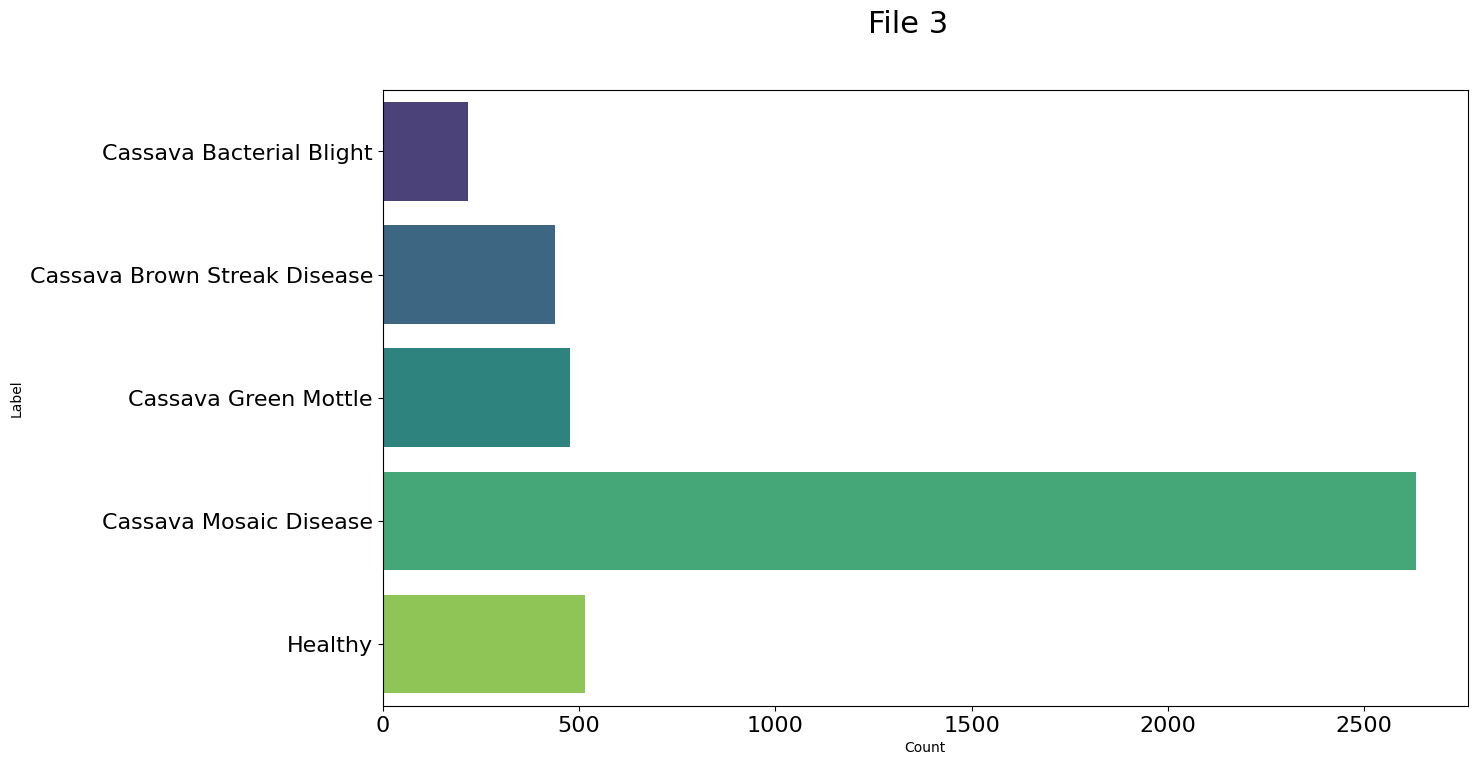

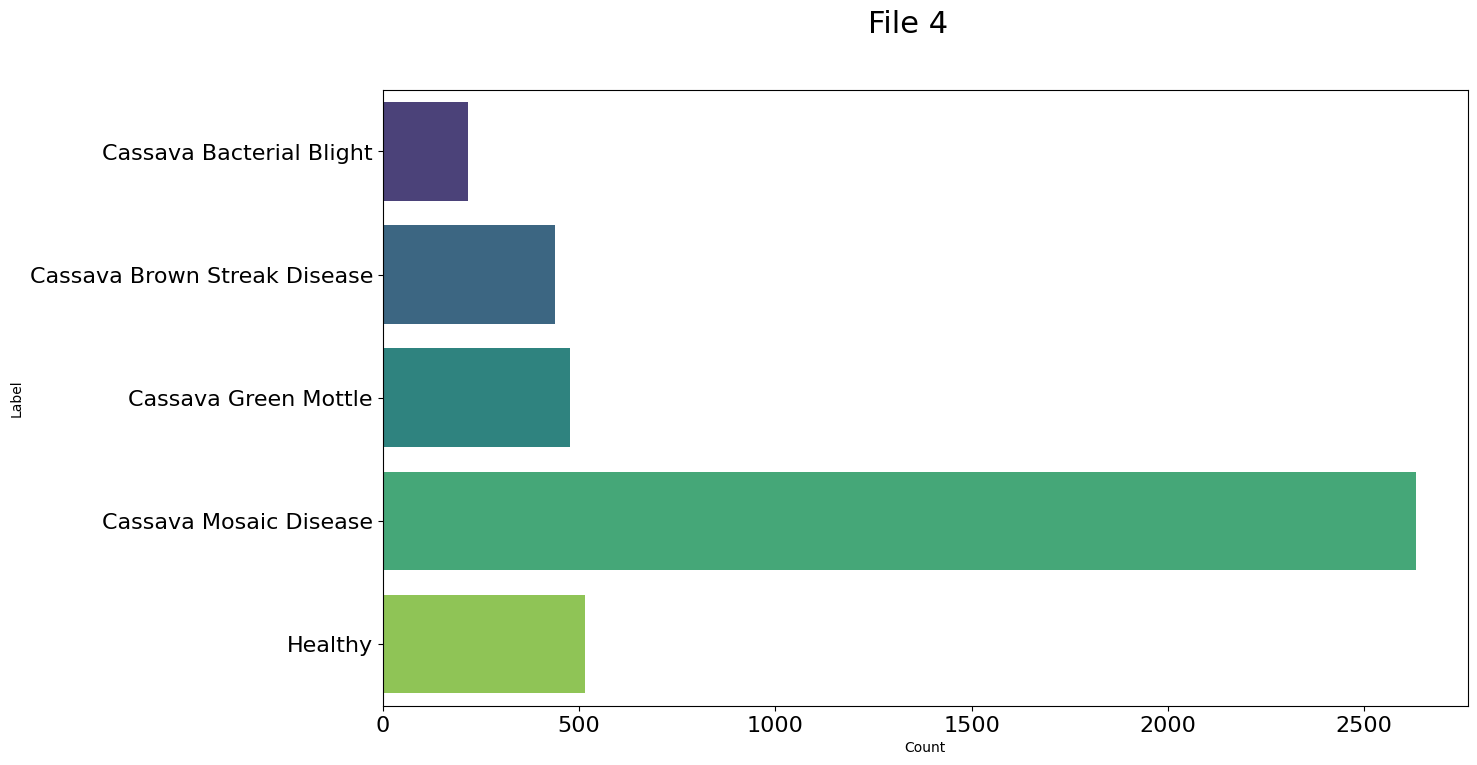

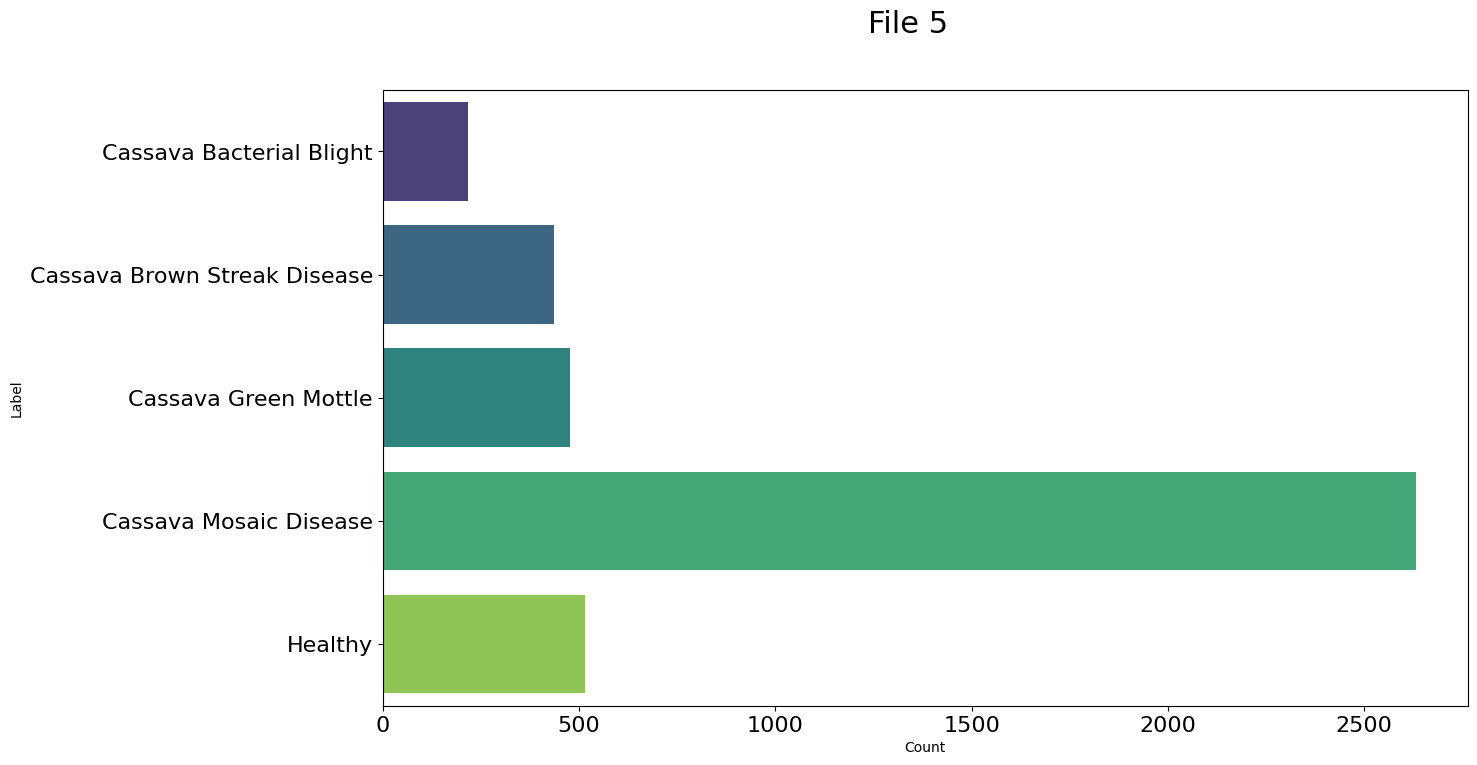

In [10]:
for fold_n in range(folds.n_splits):
    label_count = train[train['file'] == fold_n].groupby('label', as_index=False).count()
    label_count.rename(columns={'image_id': 'Count', 'label': 'Label'}, inplace=True)
    label_count['Label'] = label_count['Label'].apply(lambda x: CLASSES[x])

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    fig.suptitle(f'File {fold_n+1}', fontsize=22)
    ax = sns.barplot(x=label_count['Count'], y=label_count['Label'], palette='viridis')
    ax.tick_params(labelsize=16)

    plt.show()